In [2]:
import pandas as pd
import glob
import re
import numpy as np

from matplotlib import font_manager, rc #한글지원
import platform
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc("font",family='Malgun Gothic') #한글_글꼴
plt.rcParams['axes.unicode_minus'] = False #음수표시

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.preprocessing import LabelEncoder

In [3]:
file_dir = './data/'

In [277]:
df_h.columns

Index(['가입자 일련번호', '시도코드', '성별코드', '연령대 코드(5세단위)', '신장(5Cm단위)', '체중(5Kg 단위)',
       '허리둘레', '수축기 혈압', '이완기 혈압', '식전혈당(공복혈당)', '총 콜레스테롤', '트리글리세라이드',
       'HDL 콜레스테롤', 'LDL 콜레스테롤', '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST',
       '(혈청지오티)ALT', '감마 지티피', '구강검진 수검여부', 'bmi', 'map', 'ast_alt',
       'ast_alt2'],
      dtype='object')

In [23]:
df_h = pd.read_csv(file_dir + '건강검진/건강검진_2020.CSV', encoding='euc-kr')
df_h = df_h.drop(['시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '흡연상태', '음주여부', '치아우식증유무', '치석', '기준년도', '데이터 공개일자'], axis = 1)
df_h.dropna(inplace=True)
df_h.iloc[3]

가입자 일련번호          7.0
시도코드             44.0
성별코드              1.0
연령대 코드(5세단위)      9.0
신장(5Cm단위)       165.0
체중(5Kg 단위)       80.0
허리둘레             93.0
수축기 혈압          112.0
이완기 혈압           73.0
식전혈당(공복혈당)      250.0
총 콜레스테롤         119.0
트리글리세라이드        265.0
HDL 콜레스테롤        26.0
LDL 콜레스테롤        40.0
혈색소              15.7
요단백               1.0
혈청크레아티닌           0.7
(혈청지오티)AST       18.0
(혈청지오티)ALT       20.0
감마 지티피           35.0
구강검진 수검여부         1.0
Name: 6, dtype: float64

In [4]:
df_h = pd.read_csv(file_dir + '건강검진/건강검진_2020.CSV', encoding='euc-kr')
df_h = df_h.drop(['시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '흡연상태', '음주여부', '치아우식증유무', '치석', '기준년도', '데이터 공개일자'], axis = 1)

### 파생변수 생성
df_h['bmi']=df_h['체중(5Kg 단위)'] / ((df_h['신장(5Cm단위)']/100)**2)
df_h['map'] = (2*df_h['이완기 혈압']+df_h['수축기 혈압'])/3
df_h['ast_alt'] = df_h['(혈청지오티)AST'] / df_h['(혈청지오티)ALT']

df_h['ast_alt2'] = 0 # 간손상
df_h[df_h['ast_alt'] >= 0]['ast_alt2'] = 1 # 간 외 조직 손상

col = ['가입자 일련번호', '시도코드', '성별코드', 'bmi', 'map', '식전혈당(공복혈당)', '총 콜레스테롤',
       '트리글리세라이드', '혈색소', '요단백', '혈청크레아티닌', 'ast_alt2', '감마 지티피']

df_h = df_h[col]
df_h.dropna(inplace=True)

display(df_h.shape, df_h[:5])

C:\Users\USER\AppData\Local\Temp\ipykernel_8944\4012843700.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h[df_h['ast_alt'] >= 0]['ast_alt2'] = 1 # 간 외 조직 손상


(400251, 13)

,가입자 일련번호,시도코드,성별코드,bmi,map,식전혈당(공복혈당),총 콜레스테롤,트리글리세라이드,혈색소,요단백,혈청크레아티닌,ast_alt2,감마 지티피
0,1,36,1,22.038567,95.000000,90.0,188.0,58.0,15.0,1.0,1.1,0,21.0
4,5,41,2,20.811655,107.333333,110.0,220.0,171.0,12.4,1.0,0.7,0,14.0
5,6,27,1,24.835646,86.000000,86.0,234.0,183.0,16.4,1.0,1.1,0,26.0
6,7,44,1,29.384757,86.000000,250.0,119.0,265.0,15.7,1.0,0.7,0,35.0
8,9,41,2,22.222222,88.666667,104.0,177.0,61.0,13.3,1.0,0.7,0,39.0


In [5]:
# 진료내역
df_t = None
for val in glob.glob(file_dir + '진료내역/*.csv'):
    temp_t = pd.read_csv(val, encoding = 'euc-kr', usecols=[1, 6, 7, 8 , 9, 10, 11, 12, 17])
    temp_t = temp_t.astype({'서식코드':'category', '진료과목코드':'category'})
    df_t = pd.concat([df_t, temp_t])
display(df_t.shape, df_t[:5])

(11727248, 9)

,가입자 일련번호,요양개시일자,서식코드,진료과목코드,주상병코드,부상병코드,요양일수,입내원일수,총처방일수
0,29,2020-12-21,3,1,I109,E785,1,1,0
1,29,2020-12-14,3,1,I109,E785,1,1,7
2,255,2020-04-20,3,1,I109,I251,1,1,30
3,255,2020-04-16,3,1,I109,I251,1,1,30
4,2406,2020-12-30,3,1,I109,E780,1,1,0


In [6]:
# 상병코드
kcd = pd.read_csv(file_dir + '상병코드.csv', encoding='cp949', usecols=[0,1,2])
display(kcd.shape, kcd[:5])

(47798, 3)

,상병기호,한글명,영문명
0,A00,콜레라,Cholera
1,A000,비브리오 콜레라 01 콜레라형균에 의한 콜레라,Cholera due to Vibrio cholerae 01_ biovar chol...
2,A000,고전적 콜레라,Classical cholera
3,A001,비브리오 콜레라 01 엘토르형균에 의한 콜레라,Cholera due to Vibrio cholerae 01_ biovar eltor
4,A001,엘토르 콜레라,Cholera eltor


----

In [7]:
# 대유형 코드 list 생성
kcd_lis = []
for alpha in range(ord('A'), ord('Z')+1):
    for i in range(10):
        kcd_lis.append(chr(alpha)+str(i)+'0')
kcd_lis[:5]

['A00', 'A10', 'A20', 'A30', 'A40']

In [31]:
kcd_df[kcd_df['상병기호'] == 'M50']

,상병기호,한글명,영문명
119,M50,경추간판장애,Cervical disc disorders


In [8]:
# 상병코드 정제
kcd_df = kcd[kcd['상병기호'].isin(kcd_lis)]
kcd_df = kcd_df[kcd_df.duplicated(['상병기호'], keep='first') == False]
kcd_df = kcd_df.reset_index(drop=True)
kcd_df

,상병기호,한글명,영문명
0,A00,콜레라,Cholera
1,A20,페스트,Plague
2,A30,나병[한센병],Leprosy[Hansen’s disease]
3,A40,연쇄알균패혈증,Streptococcal sepsis
4,A50,선천매독,Congenital syphilis
...,...,...,...
239,Z50,재활처치를 포함한 치료를 위하여 보건서비스와 접하고 있는 사람,Persons encountering health services for care ...
240,Z60,사회적 환경에 관련된 문제,Problems related to social environment
241,Z70,성적 태도_ 행동 및 지향에 관련된 상담,Counselling related to sexual attitude_ behavi...
242,Z80,악성 신생물의 가족력,Family history of malignant neoplasm


In [9]:
# 변수생성
df_t['상병기호'] = df_t['주상병코드'].str.slice(0,2)
df_t['상병기호'] = df_t['상병기호'].str.replace('_', '0')
df_t['상병기호'] = df_t['상병기호'].str.ljust(width=3, fillchar='0')
df_t['상병기호']

0          I10
1          I10
2          I10
3          I10
4          I10
          ... 
3905190    H50
3905191    S90
3905192    G00
3905193    J80
3905194    H50
Name: 상병기호, Length: 11727248, dtype: object

---

In [26]:
df = pd.merge(df_h, df_t.iloc[:, [0, -1]], on='가입자 일련번호')
df[:5]
df[df['시도코드'] == 44]

,가입자 일련번호,시도코드,성별코드,연령대 코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,수축기 혈압,이완기 혈압,식전혈당(공복혈당),...,HDL 콜레스테롤,LDL 콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,구강검진 수검여부,상병기호
40,7,44,1,9,165,80,93.0,112.0,73.0,250.0,...,26.0,40.0,15.7,1.0,0.7,18.0,20.0,35.0,1,J00
41,7,44,1,9,165,80,93.0,112.0,73.0,250.0,...,26.0,40.0,15.7,1.0,0.7,18.0,20.0,35.0,1,J00
42,7,44,1,9,165,80,93.0,112.0,73.0,250.0,...,26.0,40.0,15.7,1.0,0.7,18.0,20.0,35.0,1,J20
43,7,44,1,9,165,80,93.0,112.0,73.0,250.0,...,26.0,40.0,15.7,1.0,0.7,18.0,20.0,35.0,1,A00
44,7,44,1,9,165,80,93.0,112.0,73.0,250.0,...,26.0,40.0,15.7,1.0,0.7,18.0,20.0,35.0,1,H60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4588539,999861,44,2,9,150,50,70.0,116.0,82.0,97.0,...,42.0,96.0,12.1,1.0,0.7,18.0,13.0,25.0,0,K20
4588540,999861,44,2,9,150,50,70.0,116.0,82.0,97.0,...,42.0,96.0,12.1,1.0,0.7,18.0,13.0,25.0,0,I10
4588541,999861,44,2,9,150,50,70.0,116.0,82.0,97.0,...,42.0,96.0,12.1,1.0,0.7,18.0,13.0,25.0,0,M50
4588542,999861,44,2,9,150,50,70.0,116.0,82.0,97.0,...,42.0,96.0,12.1,1.0,0.7,18.0,13.0,25.0,0,I10


In [10]:
df = pd.merge(df_h, df_t.iloc[:, [0, -1]], on='가입자 일련번호')
df[:5]

,가입자 일련번호,시도코드,성별코드,bmi,map,식전혈당(공복혈당),총 콜레스테롤,트리글리세라이드,혈색소,요단백,혈청크레아티닌,ast_alt2,감마 지티피,상병기호
0,1,36,1,22.038567,95.000000,90.0,188.0,58.0,15.0,1.0,1.1,0,21.0,L60
1,1,36,1,22.038567,95.000000,90.0,188.0,58.0,15.0,1.0,1.1,0,21.0,L60
2,5,41,2,20.811655,107.333333,110.0,220.0,171.0,12.4,1.0,0.7,0,14.0,L20
3,5,41,2,20.811655,107.333333,110.0,220.0,171.0,12.4,1.0,0.7,0,14.0,B30
4,5,41,2,20.811655,107.333333,110.0,220.0,171.0,12.4,1.0,0.7,0,14.0,K20


In [11]:
lis = df['상병기호'].value_counts()[:5].keys() #가장 많이 걸리는 질병 top5

df2 = df[df['상병기호'].isin(lis)]
df2 = df2[df2.duplicated(keep='first') == False]
df2 = df2.reset_index(drop=True)

In [12]:
# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 데이터에 LabelEncoder 적용
encoded_data = label_encoder.fit_transform(df2['상병기호'])
df2['상병기호'] = encoded_data

In [14]:
lis

Index(['I10', 'M50', 'J00', 'J20', 'E10'], dtype='object')

In [13]:
label_encoder.classes_

array(['E10', 'I10', 'J00', 'J20', 'M50'], dtype=object)

#### 파일 저장

In [15]:
df2.to_csv(file_dir + 'hackathon.csv', index=False)
display(df2)

,가입자 일련번호,시도코드,성별코드,bmi,map,식전혈당(공복혈당),총 콜레스테롤,트리글리세라이드,혈색소,요단백,혈청크레아티닌,ast_alt2,감마 지티피,상병기호
0,6,27,1,24.835646,86.000000,86.0,234.0,183.0,16.4,1.0,1.1,0,26.0,1
1,7,44,1,29.384757,86.000000,250.0,119.0,265.0,15.7,1.0,0.7,0,35.0,2
2,7,44,1,29.384757,86.000000,250.0,119.0,265.0,15.7,1.0,0.7,0,35.0,3
3,9,41,2,22.222222,88.666667,104.0,177.0,61.0,13.3,1.0,0.7,0,39.0,2
4,11,41,2,22.892820,89.333333,92.0,152.0,175.0,13.0,1.0,0.7,0,12.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330953,999992,11,2,27.055151,102.333333,99.0,174.0,82.0,15.3,1.0,0.7,0,16.0,0
330954,999993,30,1,29.387755,89.333333,98.0,142.0,121.0,15.1,1.0,0.8,0,36.0,2
330955,999996,41,2,26.159334,96.000000,124.0,178.0,301.0,13.6,1.0,0.6,0,18.0,4
330956,999997,26,2,21.484375,76.000000,98.0,288.0,93.0,14.0,1.0,0.8,0,19.0,3


----

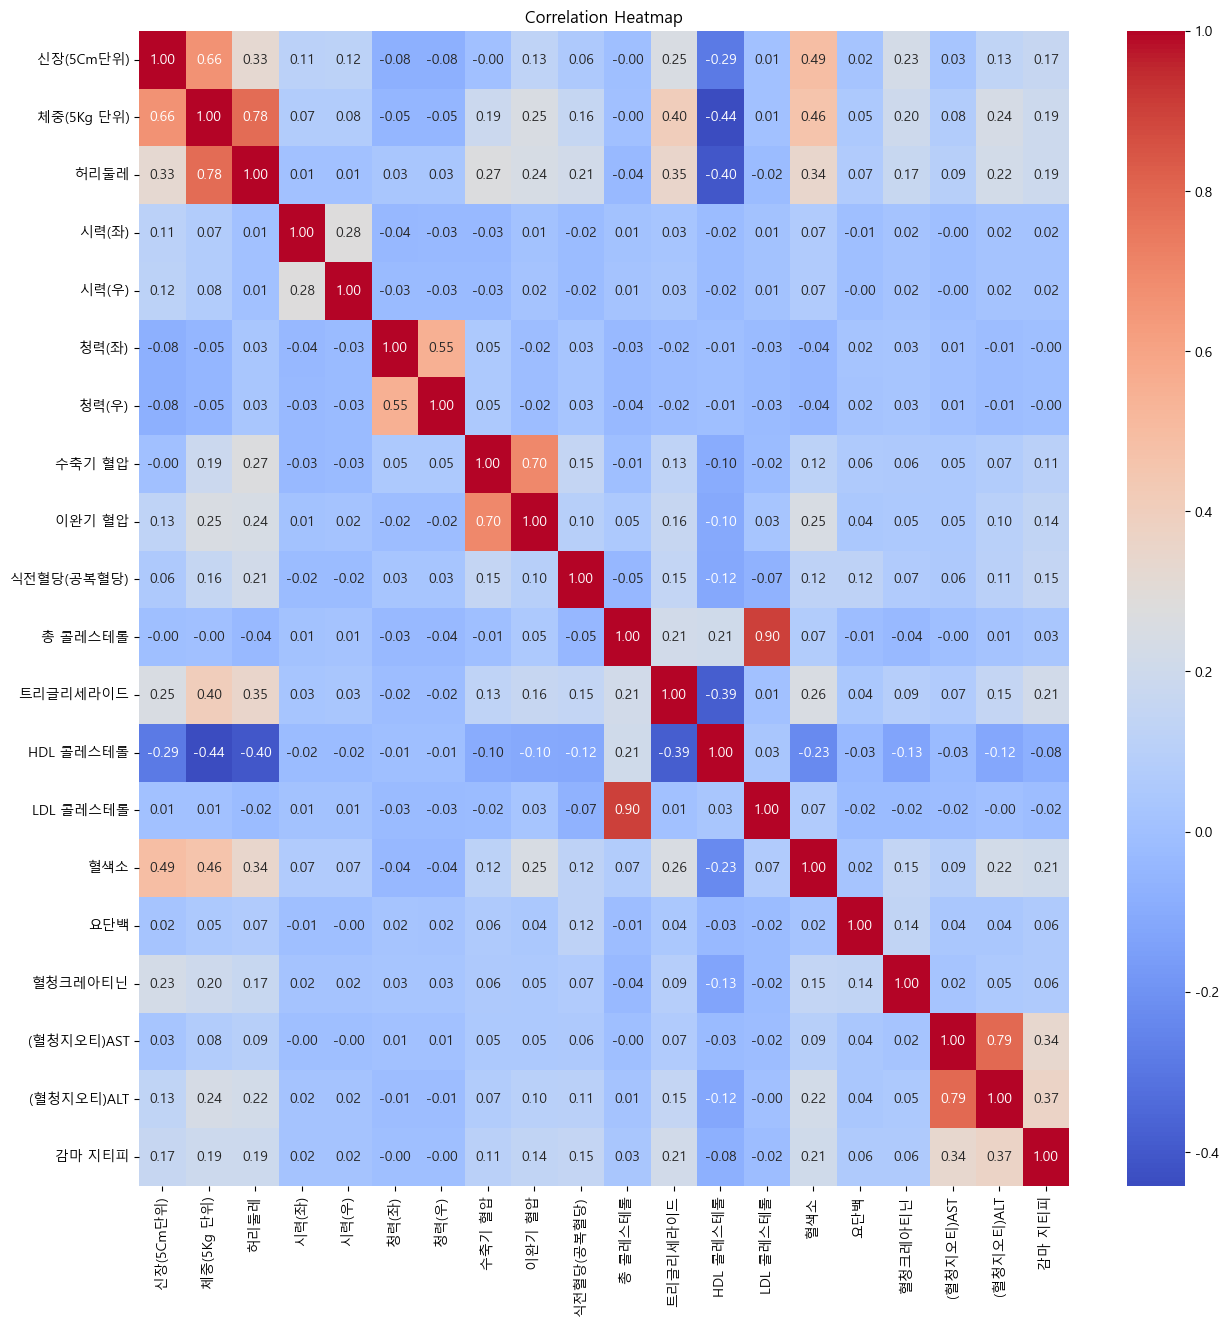

In [239]:
correlation_matrix = df2.iloc[:, 3:-2].corr()

# 히트맵 그리기
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()